In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import nltk
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as km

import hdbscan
from sklearn.cluster import DBSCAN


# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

### Stemming & tokenizing & Word2vec

In [2]:
path = "../../datas/"
stopwords = ['',' ''다','좀', '있다', '조금', '요', '되어다', '더', '너', '친', '가자', '아주', '그렇다', '바라','싶다','습니다','좀',
             '및', '...', '도', '수', '나다', '엄청', '것', '점', '등', '사', '에', '옆','이다','보다', '되다', '항상', '어요'
            , '실', '만', '정']
data = pd.read_csv(path+"v5_category_re_token_sum.csv")
reviews = data['highlight_review']

new_list = []
for r in range(len(data)):
    try: 
        rv = reviews.iloc[r]
        rv = rv.split(" ")
        rv.append(data['category'].iloc[r])
        rv = [re.compile('[^가-힣]+').sub("", r) for r in rv]
        rv = [re.compile('[은, 는, 이, 도]+').sub("", r) for r in rv]
        rv = [r.replace(r, " ") if len(r)<1 or r in stopwords else r for r in rv]
        new_list.append(rv)

    except:
        new_list.append("")

# vocabs = [word for word in new_list if word not in stopwords and len(word)>1]
print("total words num: ", len(new_list))
data['cat_plus_rv'] = new_list
reviews = data['cat_plus_rv']
model = Word2Vec(reviews, sg=1, # skinp-gram: 중심단어로 주변단어 예측
                 vector_size=200,
                 workers=6, 
                 window=5,      # 중심 단어로부터 좌우 n개까지 학습에 적용
                 min_count=100, # 전체 문서에서 최소 n회 이상 출현 단어로 학습
                 sample=0.001
                ) 

word_vectors = model.wv.vectors

vocabs = list(model.wv.index_to_key)
# vocabs = [word for word in vocabs if word not in stopwords and len(word)>1]
word_vectors_list = [model.wv[v] for v in vocabs]

print(len(word_vectors), len(vocabs), vocabs)

total words num:  120997
375 375 ['좋다', '메인시설', '서비스', ' ', '친절하다', '만족', '너무', '사장님', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '전망', '위치', '화장실', '수영장', '자다', '깔끔하다', '정말', '많다', '가격', '만족하다', '계곡', '다', '하다', '없다', '뷰', '샤워실', '개수대', '직원분들', '넘다', '가깝다', '모두', '샤워장', '넓다', '경치', '오다', '괜찮다', '아쉽다', '조용하다', '방', '음식조식', '매우', '비품', '따뜻하다', '가다', '관리', '편하다', '친절', '너무좋다', '않다', '만족스럽다', '관리가', '글램핑', '뷰가', '캠핑장', '풍경', '또', '주변', '너무너무', '불편하다', '아들', '진짜', '놀다', '내부', '잘되어다', '들다', '편의시설', '예쁘다', '사장님께서', '청결하다', '사트', '같다', '물', '벌레', '온수', '최고다', '카라반', '고', '쁘다', '쉬다', '많', '바베큐', '벌레가', '매점', '바로', '좋아하다', '생각보다', '완전', '나오다', '분위기가', '최고', '크다', '멀다', '안되다', '경치가', '다음에', '나무', '맛있다', '바다', '너무친절하다', '예약', '잘되다', '사모님', '저렴하다', '시원하다', '숙소', '잘나오다', '샤워시설', '차다', '용하다', '깨끗', '경치좋다', '사장님들', '매너타임', '난방', '불', '즐겁다', '시설깨끗하다', '바닥', '힘들다', '부대시설', '좁다', '주인분', '맘에', '앞에', '사장님친절하다', '주인분들', '물놀', '작다', '내외분', '화장실과', '직원분', '굉장하다', '굿', '간격', '해주다', '가성비', '가격대비', '마음에', '보내다', '서다'

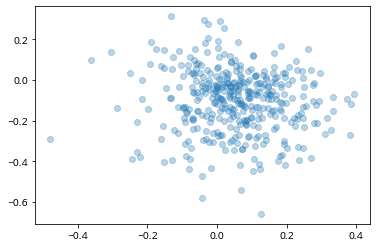

In [3]:
plt.scatter(word_vectors.T[0], word_vectors.T[1], alpha=0.3)
plt.show()

### 차원축소를 하지 않으면 전혀 군집이 되지 않음

/home/hj/anaconda3/envs/nlp/lib/python3.8/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


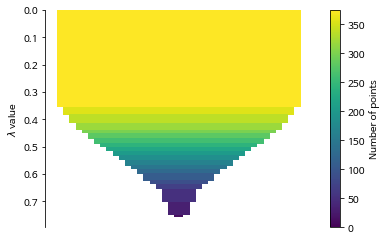

In [4]:
import hdbscan
from sklearn.cluster import DBSCAN

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(word_vectors)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [5]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(word_vectors)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(word_vectors)

# 데이터 프레임 만들기
df = pd.DataFrame(word_vectors)
df["labels"] = pred_hds
df["words"] = vocabs

print(np.unique(df["labels"]))
df.tail(2)

[-1  0  1  2  3]


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,labels,words
373,0.014630,-0.036213,-0.056339,0.163474,-0.070654,-0.172172,0.003615,0.174148,0.015917,0.086772,...,-0.103610,0.085864,0.003040,0.012423,-0.105732,-0.129494,0.047519,-0.086540,2,늘다
374,0.228528,0.049355,0.001116,-0.092683,0.136711,0.049352,0.154474,0.145766,0.196020,-0.052611,...,-0.455105,-0.088517,0.217611,-0.094924,-0.020667,0.164386,-0.258760,-0.082087,-1,글램핑다


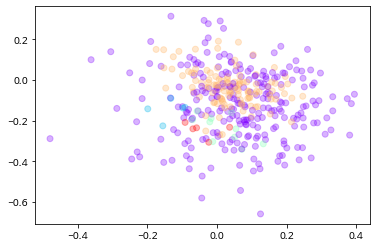

In [6]:
plt.scatter(df[0], df[1], c=df["labels"], cmap="rainbow", alpha=0.3)
plt.show()

In [9]:
for idx in np.unique(df["labels"]):
    print(f"Group{idx}\n",df[df["labels"]==idx]['words'].tolist())

Group-1
 ['좋다', '메인시설', '서비스', ' ', '친절하다', '만족', '사장님', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '전망', '위치', '화장실', '수영장', '자다', '깔끔하다', '많다', '가격', '만족하다', '계곡', '다', '하다', '없다', '뷰', '샤워실', '개수대', '가깝다', '모두', '샤워장', '넓다', '오다', '괜찮다', '아쉽다', '조용하다', '방', '음식조식', '매우', '비품', '따뜻하다', '가다', '관리', '편하다', '친절', '너무좋다', '않다', '만족스럽다', '관리가', '글램핑', '뷰가', '캠핑장', '또', '주변', '불편하다', '아들', '진짜', '놀다', '내부', '잘되어다', '들다', '편의시설', '예쁘다', '사장님께서', '청결하다', '사트', '같다', '물', '벌레', '온수', '최고다', '카라반', '쁘다', '쉬다', '많', '바베큐', '벌레가', '매점', '바로', '좋아하다', '생각보다', '완전', '나오다', '분위기가', '크다', '멀다', '안되다', '다음에', '나무', '맛있다', '바다', '너무친절하다', '예약', '잘되다', '저렴하다', '시원하다', '숙소', '잘나오다', '샤워시설', '용하다', '깨끗', '경치좋다', '매너타임', '난방', '불', '즐겁다', '시설깨끗하다', '바닥', '힘들다', '부대시설', '좁다', '맘에', '사장님친절하다', '물놀', '작다', '간격', '해주다', '가성비', '가격대비', '마음에', '보내다', '공기', '부족하다', '재밌다', '나무가', '분위기좋다', '시간', '심하다', '계곡물', '에어컨', '아니다', '냄새', '나무그늘', '편리하다', '비싸다', '냄새가', '잘하다', '데크', '공간', '바다가', '접근성', '뷰좋다', '모기', '제일', '개수대가', '놀

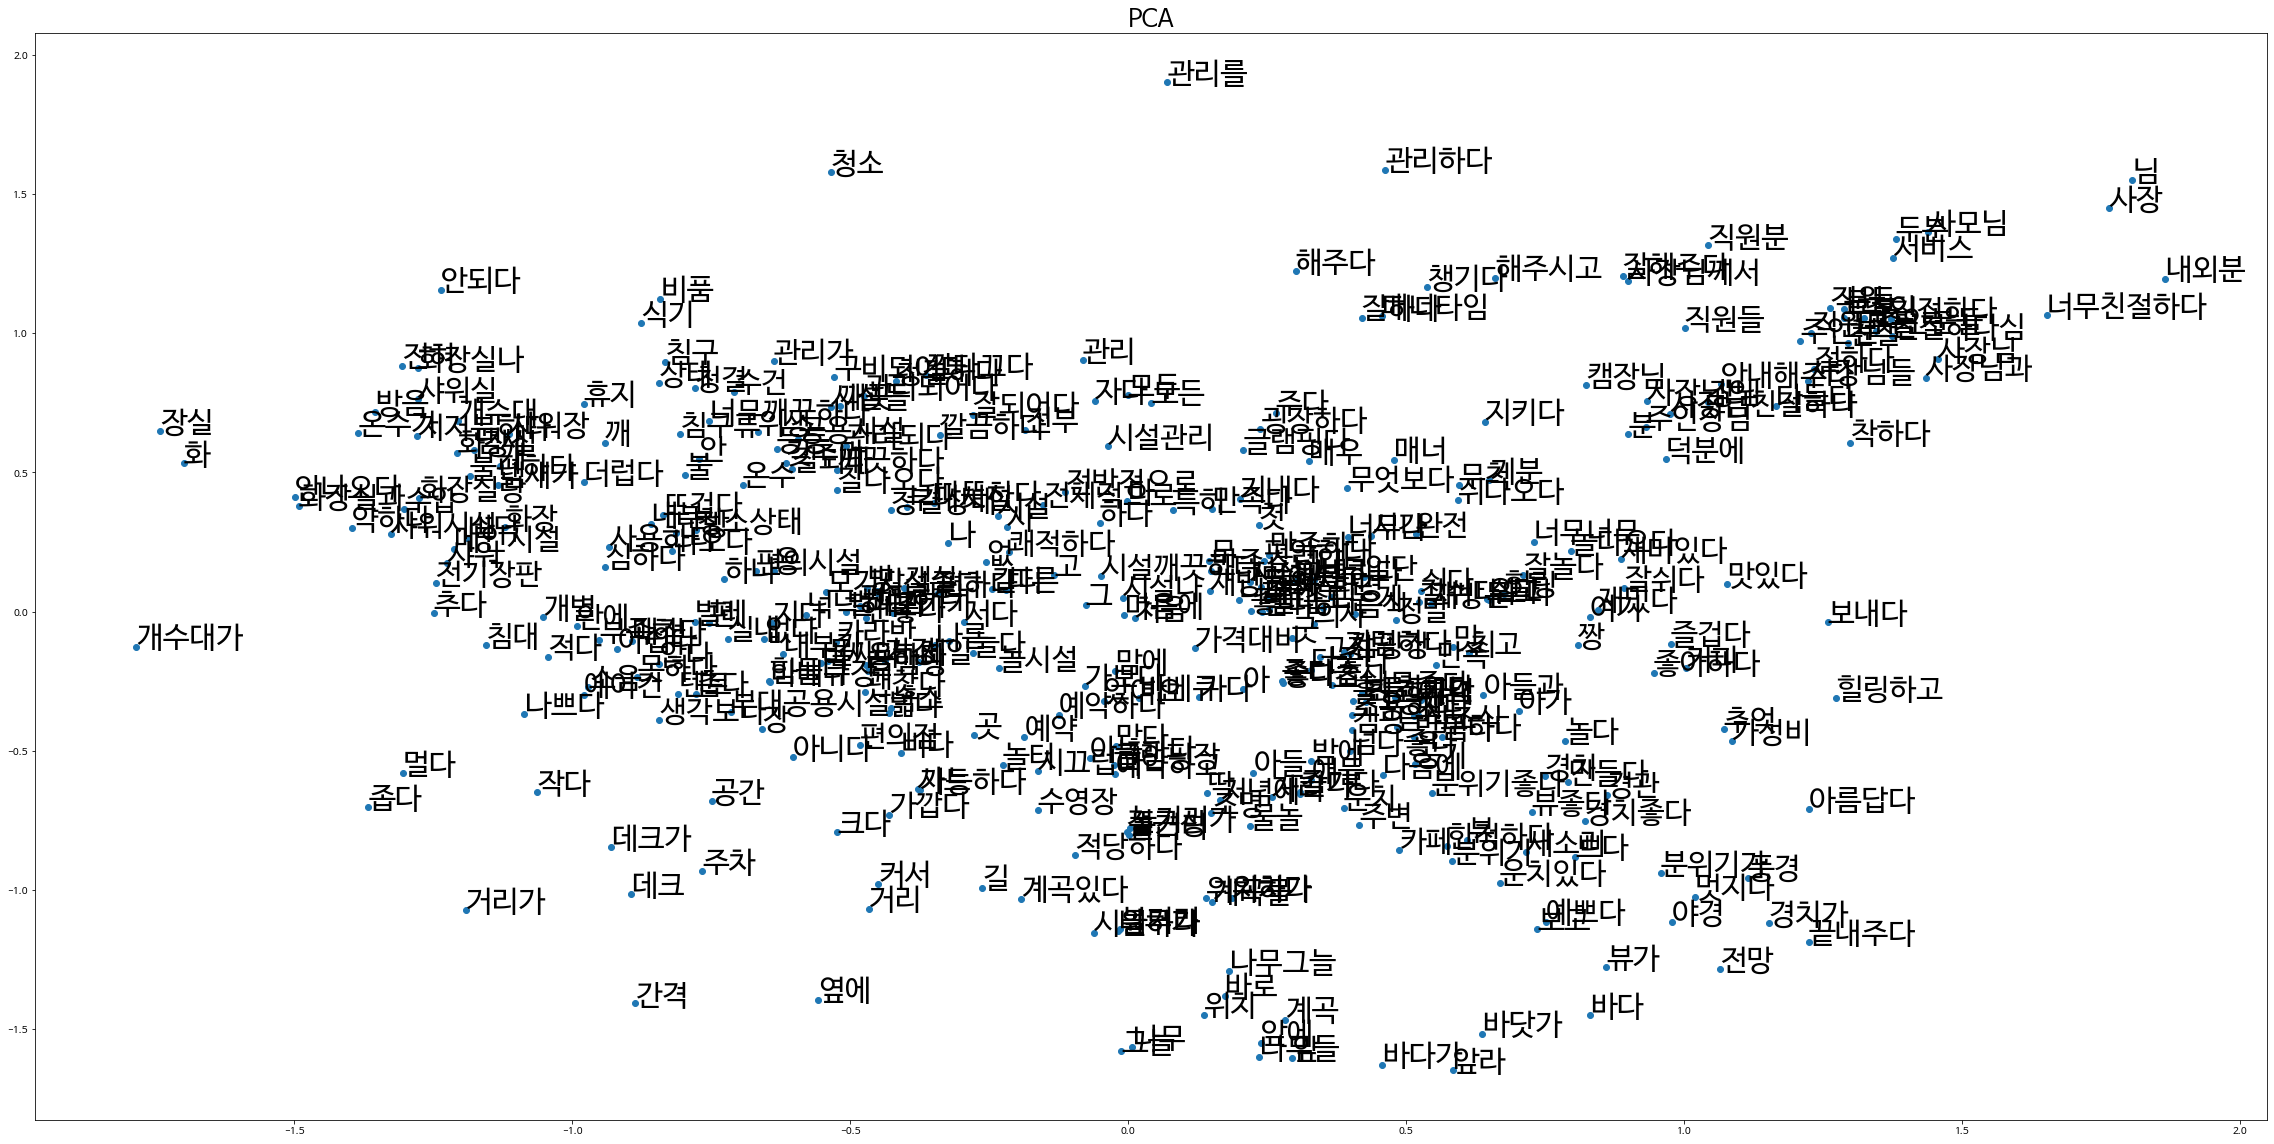

In [10]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(word_vectors)
pca_df = pd.DataFrame(pca_fit, index=vocabs, columns=['x', 'y'])

plt.figure(figsize=(40, 20))
plt.title("PCA", fontsize= 25)
plt.scatter(pca_df["x"], pca_df["y"])

for word, pos in pca_df.iterrows():
    plt.annotate(word, pos, fontsize=30)
plt.show()

#xys = pca.fit_transform(word_vectors)
# xs = xys[:, 0]
# ys = xys[:, 1]

# plt.figure(figsize=(40, 20))
# plt.title("PCA clustering")
# plt.scatter(xs, ys)
# for i, v in enumerate(vocabs):
#     plt.annotate(v, xy=(xs[i], ys[i]), fontsize=30)
# plt.show()

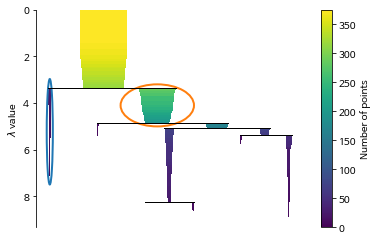

In [11]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(pca_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [18]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(pca_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(pca_df)

# 데이터 프레임 만들기
df2 = pd.DataFrame(pca_df)
df2["labels"] = pred_hds

print(np.unique(df2["labels"]), len(df2))
df2.tail(2)

[-1  0  1  2  3  4] 375


,x,y,labels
늘다,-0.280099,-0.148640,2
글램핑다,0.207185,0.579018,2


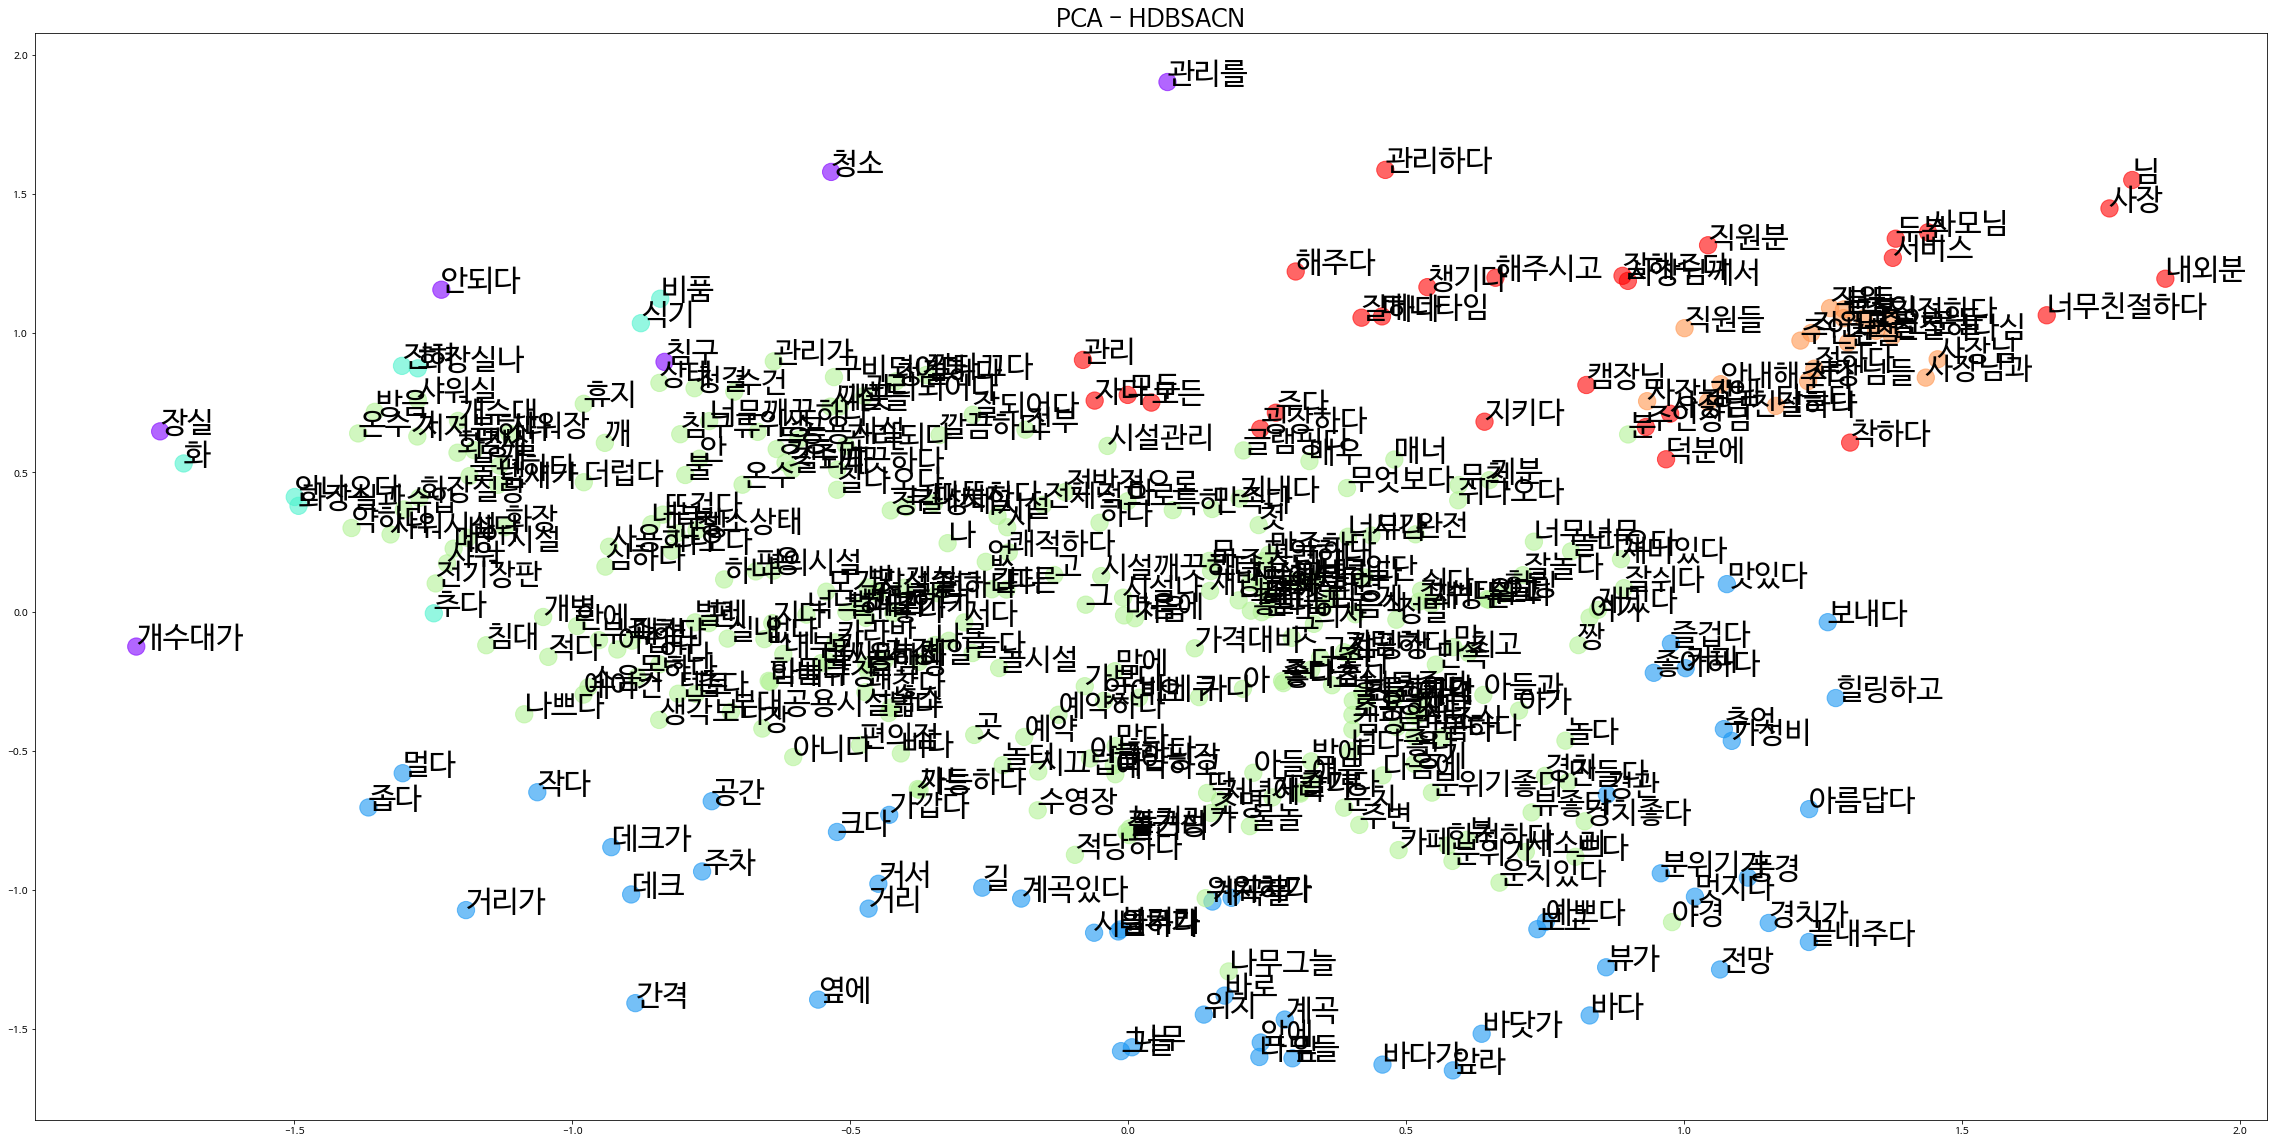

In [19]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
plt.scatter(df2["x"], df2["y"], c= df2["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df2.index):
    plt.annotate(v, xy=(df2["x"][i], df2["y"][i]), fontsize=30)

plt.show()

In [21]:
for idx in np.unique(df2["labels"]):
    print(f"Group{idx}\n",df2[df2["labels"]==idx].index.tolist())

Group-1
 ['안되다', '침구', '개수대가', '청소', '관리를', '장실']
Group0
 ['전망', '위치', '계곡', '가깝다', '뷰가', '풍경', '예쁘다', '바로', '좋아하다', '분위기가', '크다', '멀다', '경치가', '나무', '맛있다', '바다', '시원하다', '즐겁다', '좁다', '앞에', '작다', '간격', '가성비', '보내다', '나무가', '앞', '계곡물', '데크', '공간', '바다가', '멋지다', '거리', '그늘', '경관', '거리가', '힐링하고', '계곡있다', '앞라', '위치가', '끝내주다', '주차', '바닷가', '옆에', '아름답다', '커서', '추억', '나무들', '커피', '보고', '데크가', '길', '볼거리']
Group1
 ['비품', '화장실과', '안나오다', '추다', '화', '식기', '화장실나', '전혀']
Group2
 ['좋다', '메인시설', ' ', '만족', '너무', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '화장실', '수영장', '깔끔하다', '정말', '많다', '가격', '만족하다', '다', '하다', '없다', '뷰', '샤워실', '개수대', '넘다', '샤워장', '넓다', '경치', '오다', '괜찮다', '아쉽다', '조용하다', '방', '음식조식', '매우', '따뜻하다', '가다', '편하다', '너무좋다', '않다', '만족스럽다', '관리가', '글램핑', '캠핑장', '또', '주변', '너무너무', '불편하다', '아들', '진짜', '놀다', '내부', '잘되어다', '들다', '편의시설', '청결하다', '사트', '같다', '물', '벌레', '온수', '최고다', '카라반', '고', '쁘다', '쉬다', '많', '바베큐', '벌레가', '매점', '생각보다', '완전', '나오다', '최고', '다음에', '예약', '잘되다', '저렴하다', '숙소', '잘나오다', '샤워시설

### TSNE 축소법

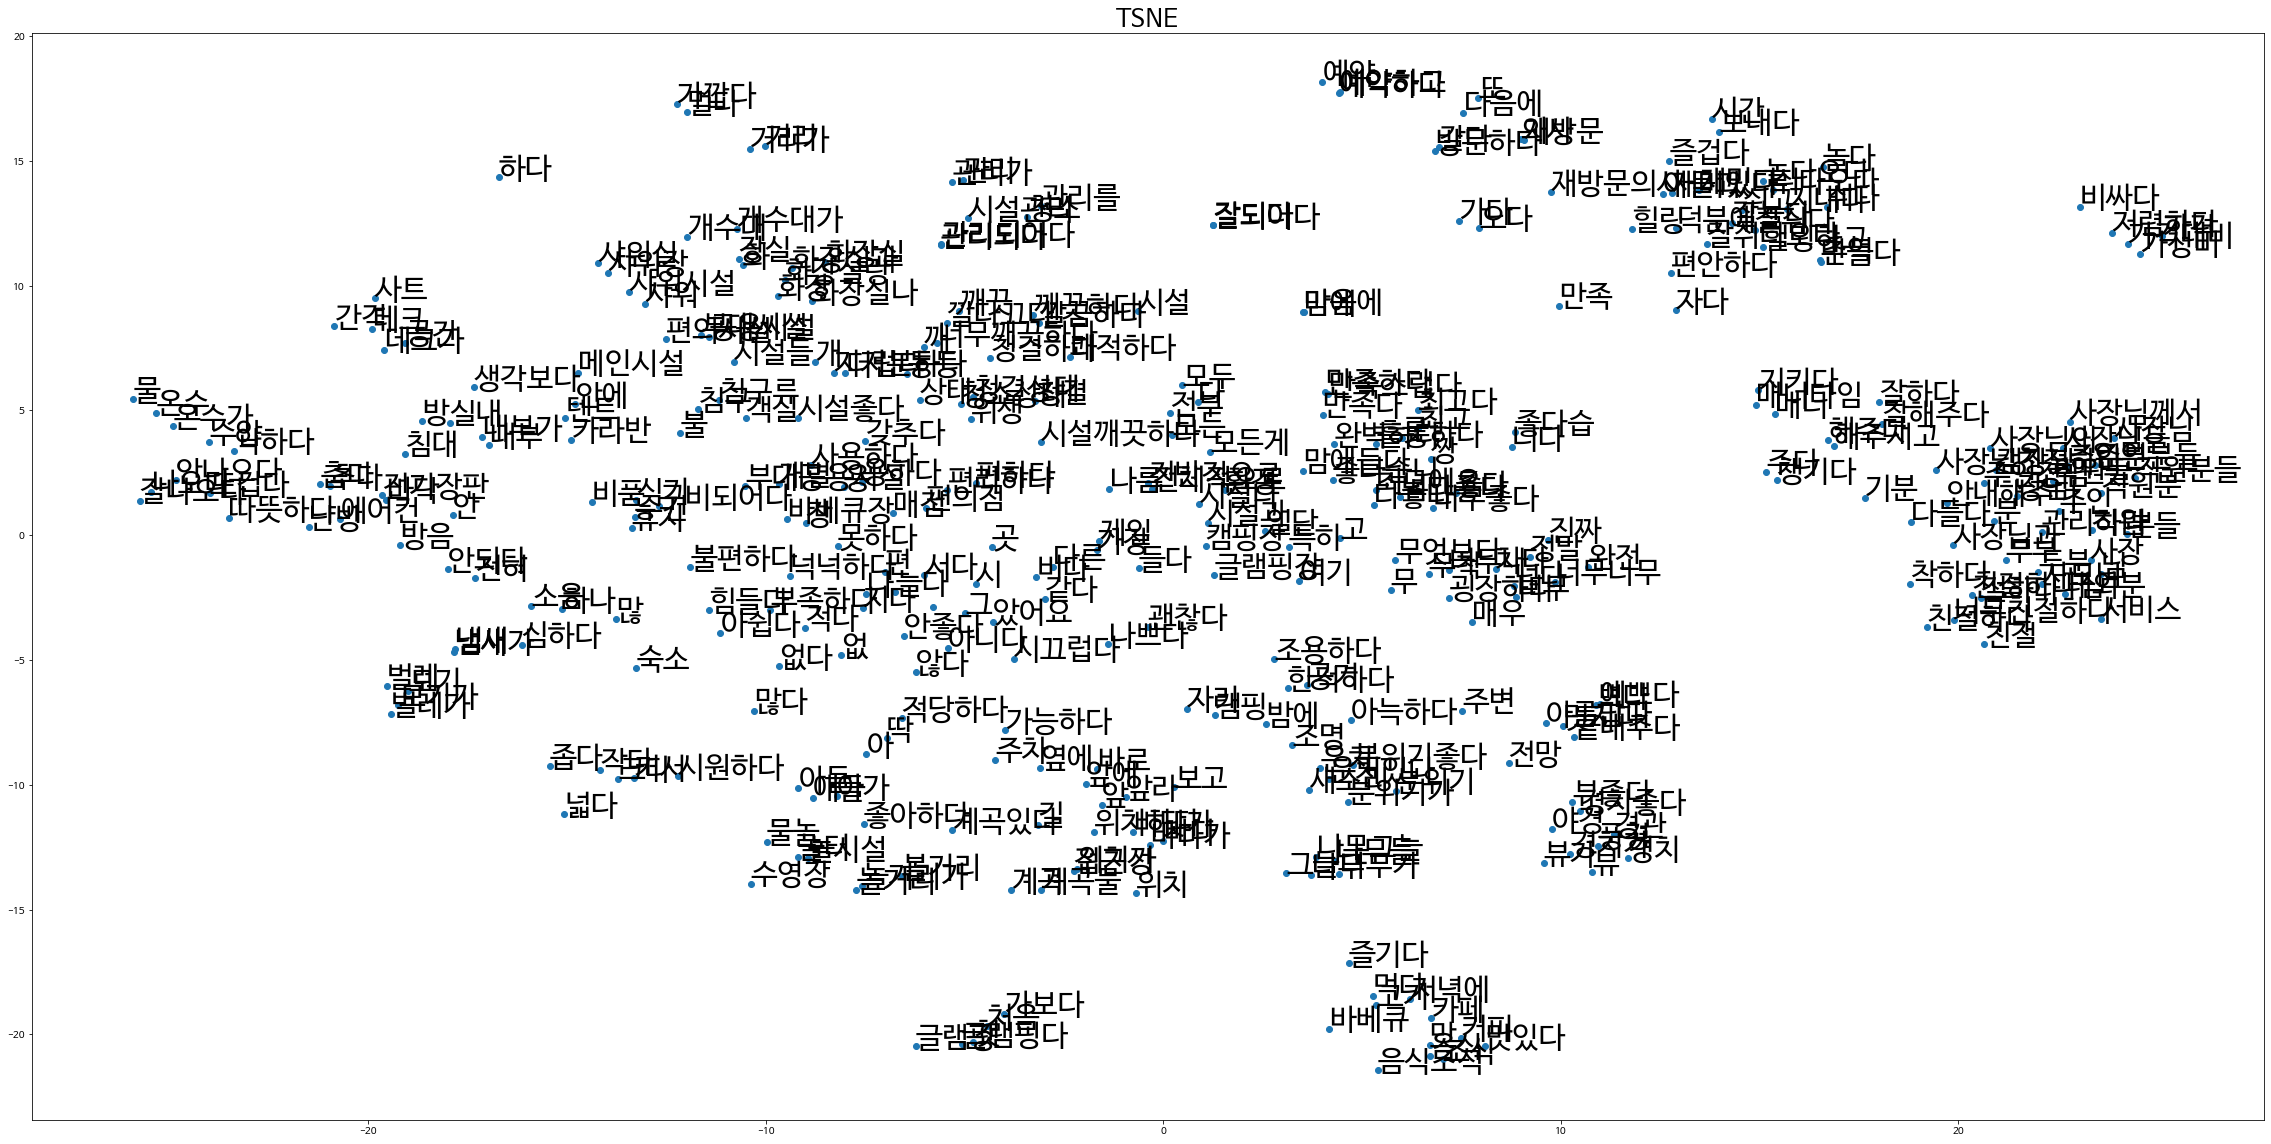

In [22]:
tsne = TSNE(learning_rate=100)
tsne_fit = tsne.fit_transform(word_vectors)
tsne_df = pd.DataFrame(tsne_fit, index=vocabs, columns=['x', 'y'])

plt.figure(figsize=(40, 20))
plt.title("TSNE", fontsize= 25)
plt.scatter(tsne_df["x"], tsne_df["y"])

for word, pos in tsne_df.iterrows():
    plt.annotate(word, pos, fontsize=30)
plt.show()

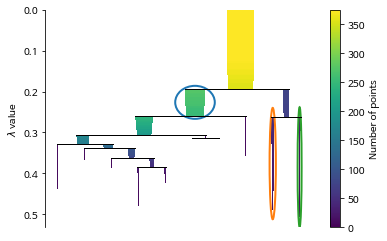

In [23]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(tsne_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [75]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=10,
                            cluster_selection_epsilon=0.3,
                            gen_min_span_tree=True,
                            match_reference_implementation=True).fit(tsne_df)
 
# 예측 데이터 생성
pred_hds = model_hds.fit_predict(tsne_df)

# 데이터 프레임 만들기
df3 = pd.DataFrame(tsne_df)
df3["labels"] = pred_hds

print(np.unique(df3["labels"]), len(df3))
df3.tail(2)

[-1  0  1  2  3  4  5  6  7] 375


,x,y,labels
늘다,-6.744754,-2.294252,7
글램핑다,-5.072153,-20.391041,-1


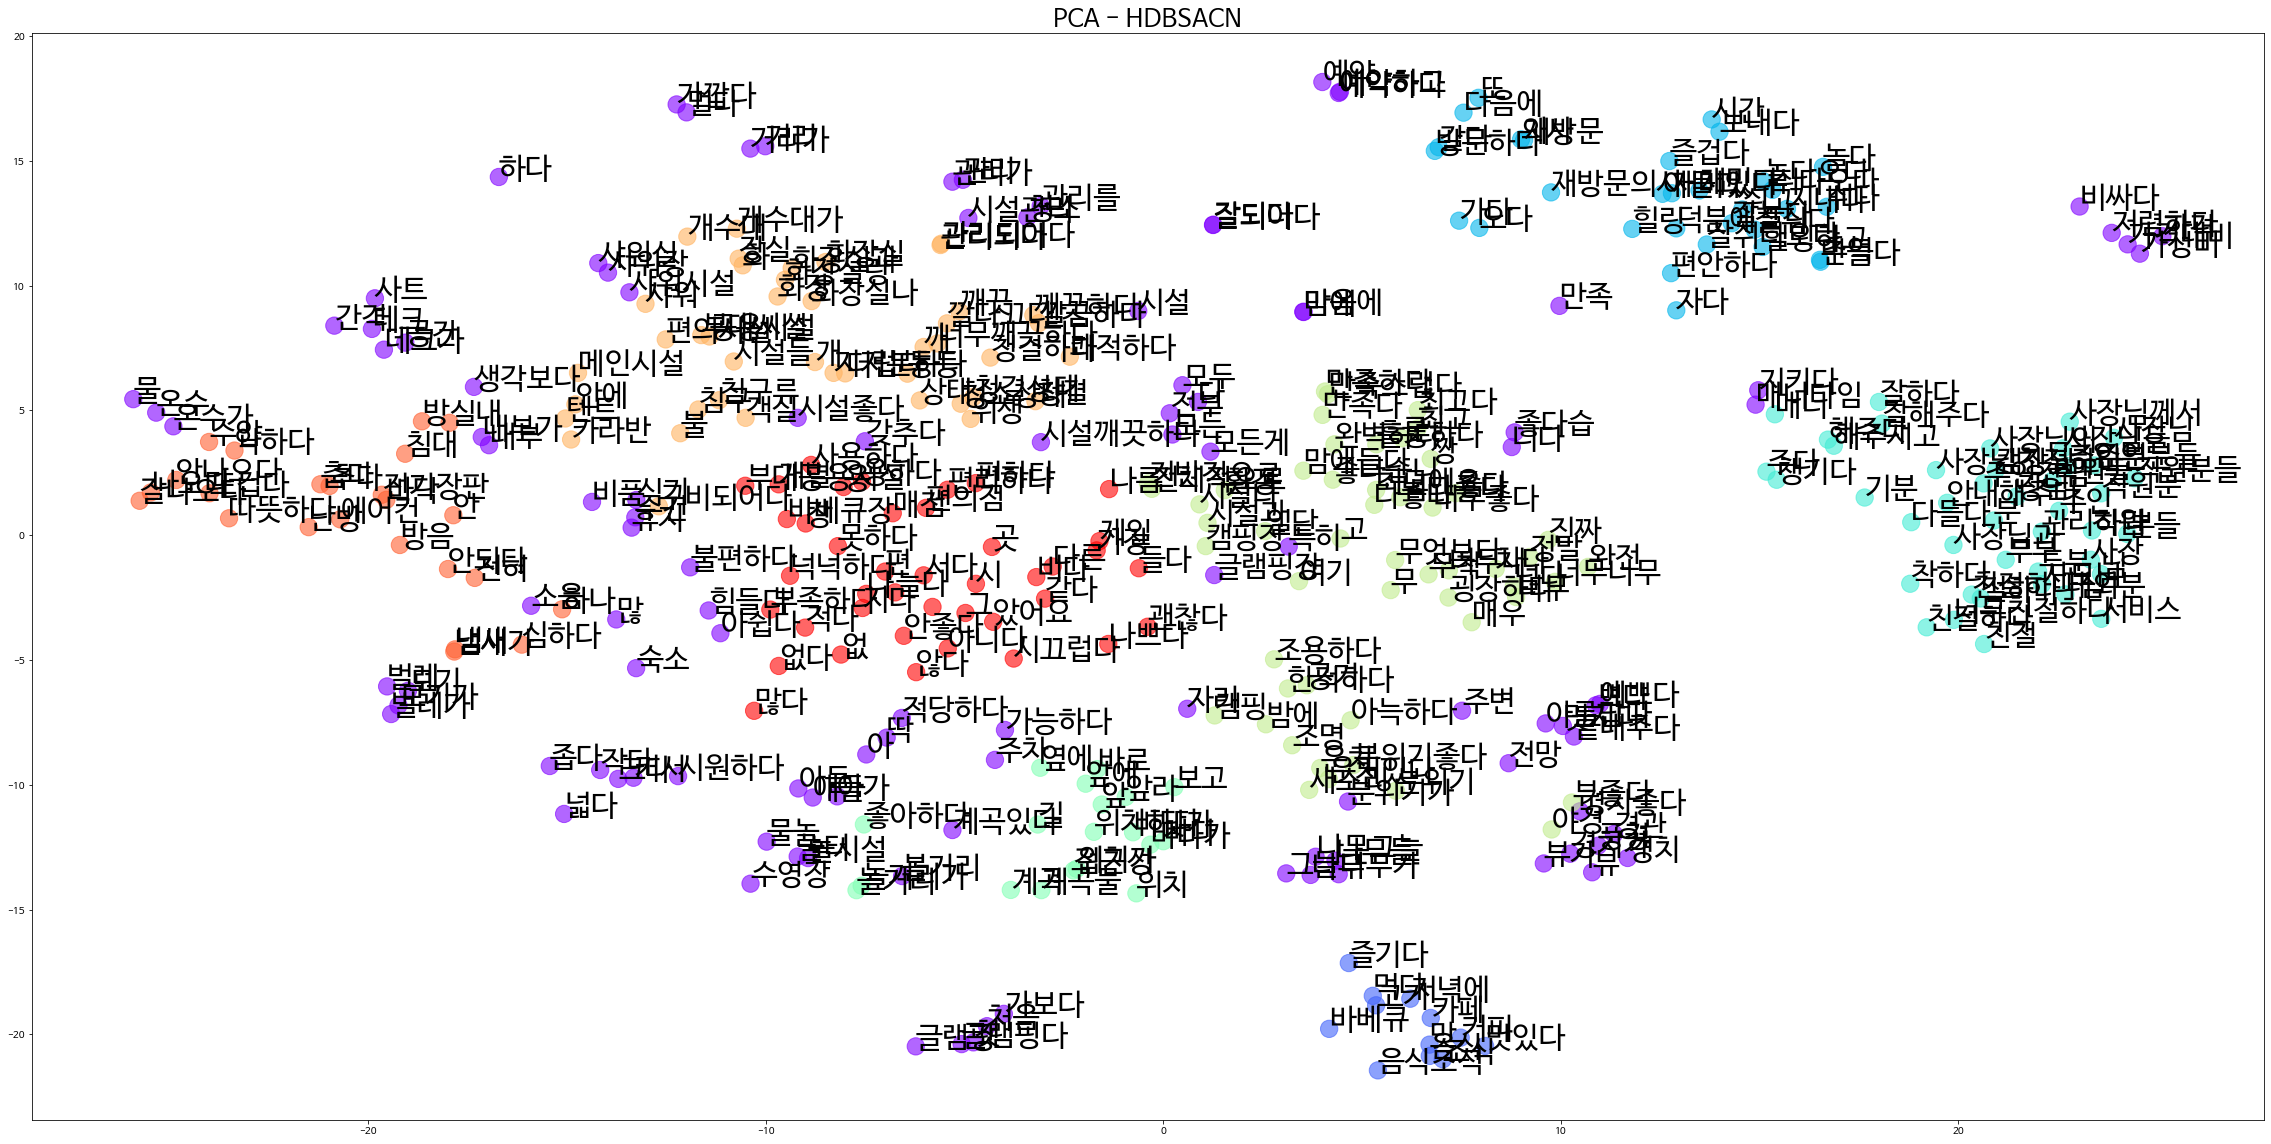

In [76]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
plt.scatter(df3["x"], df3["y"], c= df3["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df3.index):
    plt.annotate(v, xy=(df3["x"][i], df3["y"][i]), fontsize=30)

plt.show()

In [77]:
for idx in np.unique(df3["labels"]):
    print(f"Group{idx}\n",df3[df3["labels"]==idx].index.tolist())

Group-1
 ['만족', '시설', '전망', '수영장', '가격', '다', '하다', '뷰', '샤워실', '가깝다', '모두', '샤워장', '넓다', '경치', '아쉽다', '비품', '관리', '관리가', '글램핑', '뷰가', '풍경', '주변', '불편하다', '아들', '내부', '잘되어다', '예쁘다', '사트', '물', '벌레', '온수', '쁘다', '많', '벌레가', '생각보다', '분위기가', '크다', '멀다', '경치가', '나무', '예약', '잘되다', '저렴하다', '시원하다', '숙소', '샤워시설', '경치좋다', '매너타임', '시설깨끗하다', '힘들다', '좁다', '맘에', '물놀', '작다', '간격', '가성비', '가격대비', '마음에', '나무가', '나무그늘', '비싸다', '데크', '공간', '시설좋다', '모기', '모든', '멋지다', '청소', '거리', '가능하다', '소음', '그늘', '니다', '경관', '거리가', '애들', '갖추다', '온수가', '모기가', '계곡있다', '예약하다', '자리', '끝내주다', '주차', '아', '관리를', '내부가', '아름답다', '커서', '식기', '지키다', '특히', '전부', '모든게', '좋다습', '적당하다', '첫', '나무들', '가보다', '딱', '아가', '처음', '데크가', '글램핑장', '놀시설', '시설관리', '휴지', '수건', '볼거리', '놀터', '예약하고', '글램핑다']
Group0
 ['음식조식', '바베큐', '맛있다', '조식', '음식', '즐기다', '맛', '먹다', '저녁에', '카페', '커피', '고기']
Group1
 ['자다', '오다', '가다', '또', '놀다', '쉬다', '다음에', '즐겁다', '보내다', '재밌다', '시간', '편안하다', '재미있다', '힐링하고', '놀다오다', '방문하다', '갈다', '잘쉬다', '재방문', '만들다', '추억', '지내다', '덕